In [1]:
import os
import sys
import json
import math
import torch
import numpy as np

import matplotlib
# matplotlib.use("pgf")
matplotlib.rcParams.update({
    # 'font.family': 'serif',
    'font.size':12,
})
from matplotlib import pyplot as plt

from torch import nn
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
seed_everything(42)

import DiffNet
from DiffNet.networks.wgan import GoodNetwork
from DiffNet.DiffNetFEM import DiffNet2DFEM
# from DiffNet.datasets.single_instances.rectangles import RectangleManufactured
from DiffNet.datasets.single_instances.rectangles import AllenCahnIceMeltRectangle
from e18_allen_cahn_ice_melt import AllenCahnIceMelt

/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
Global seed set to 42
Global seed set to 42


In [2]:
def plot_contours(k,f,u,u_exact):
    diff = u - u_exact
    # plotting        
    fig, axs = plt.subplots(1, 5, figsize=(3*5,2),
                        subplot_kw={'aspect': 'auto'}, sharex=True, sharey=True, squeeze=True)
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])              

    # print(np.linalg.norm(diff.flatten())/self.domain_size)
    im = axs[0].imshow(f,cmap='jet')
    # fig.colorbar(im, ax=axs[0], ticks=[0.0, 4.0, 8.0, 12.0, 16.0, 20.0]); axs[0].set_title(r'$f$')
    fig.colorbar(im, ax=axs[0]); axs[0].set_title(r'$f$')
    im = axs[1].imshow(k,cmap='jet')
    fig.colorbar(im, ax=axs[1]); axs[1].set_title(r'$\nu$')
    im = axs[2].imshow(u,cmap='jet', vmin=0.0, vmax=1.0)
    fig.colorbar(im, ax=axs[2]); axs[2].set_title(r'$u_{\theta}$')
    im = axs[3].imshow(u_exact,cmap='jet', vmin=0.0, vmax=1.0)
    fig.colorbar(im, ax=axs[3]); axs[3].set_title(r'$u_{exact}$')
    im = axs[4].imshow(diff,cmap='jet')
    fig.colorbar(im, ax=axs[4]); axs[4].set_title(r'$u_{\theta}-u_{exact}$')
    plt.show()
    # plt.savefig(os.path.join(self.logger[0].log_dir, 'contour_' + str(self.current_epoch) + '.png'))
    # self.logger[0].experiment.add_figure('Contour Plots', fig, self.current_epoch)
    # plt.close('all')

In [3]:
domain_size = 64
dir_string = "allen-cahn-icemelt-2d"
max_epochs = 200

ice_water_border_init = 0.5 # at t=0, ice @ [0,0.5) and water @[0.5,1]
ice_water_border_idx = int(ice_water_border_init*domain_size)

u_tensor = np.ones((1,1,domain_size,domain_size))    
u_tensor[:,:,:,0:ice_water_border_idx] = 0.
network = torch.nn.ParameterList([torch.nn.Parameter(torch.FloatTensor(u_tensor), requires_grad=True)])
dataset = AllenCahnIceMeltRectangle(domain_size=domain_size)
basecase = AllenCahnIceMelt(network, dataset, batch_size=1, domain_size=domain_size, learning_rate=0.001)

logger = pl.loggers.TensorBoardLogger('.', name=dir_string)
# logger = pl.loggers.TensorBoardLogger('.', name="simple-resmin")
csv_logger = pl.loggers.CSVLogger(logger.save_dir, name=logger.name, version=logger.version)

early_stopping = pl.callbacks.early_stopping.EarlyStopping('loss',
    min_delta=1e-8, patience=10, verbose=False, mode='max', strict=True)
checkpoint = pl.callbacks.model_checkpoint.ModelCheckpoint(monitor='loss',
    dirpath=logger.log_dir, filename='{epoch}-{step}',
    mode='min', save_last=True)

trainer = Trainer(gpus=[0],callbacks=[early_stopping],
    checkpoint_callback=checkpoint, logger=[logger,csv_logger],
    max_epochs=max_epochs, deterministic=True, profiler="simple")

trainer.fit(basecase)
torch.save(basecase.network, os.path.join(logger.log_dir, 'network.pt'))

basecase.calc_l2_err()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Experiment logs directory ./allen-cahn-icemelt-2d/version_24 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name      | Type          | Params
--------------------------------------------
0 | network   | ParameterList | 4.1 K 
1 | N_gp      | ParameterList | 16    
2 | dN_x_gp   | ParameterList | 16    
3 | dN_y_gp   | ParameterList | 16    
4 | d2N_x_gp  | ParameterList | 16    
5 | d2N_y_gp  | ParameterList | 16    
6 | d2N_xy_gp | ParameterList | 16    
--------------------------------------------
4.1 K     Trainable params
96        Non-trainable params
4.2 K     Total params
0.017     Total estimated model params size (MB)


Epoch 0:  31%|███       | 31/100 [00:00<00:00, 167.23it/s, loss=30.9, v_num=4_24]

/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 199: 100%|██████████| 100/100 [00:00<00:00, 113.86it/s, loss=30.9, v_num=4_24]

FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  175.48         	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  0.86372        	|200            	|  172.74         	|  98.441         	|
run_training_batch                 	|  0.003796       	|20000          	|  75.92          	|  43.264         	|
optimizer_step_and_closure_0       	|  0.0035779      	|20000          	|  71.558         	|  40.778         	|
training_step_and_backward         	|  0.0034406      	|20000          	|  68.812         	|  39.214         	|
on_epoch_end                       


J =  6.298815822625346e-05
usol.shape = (64, 64)
uex.shape = (64, 64)
||u_sol||, ||uex|| =  0.8120607449225141 0.0
||e||_{{L2}} =  0.8120607449225141
||e|| (vector-norm) =  0.8110700845718384


J =  6.298815822625346e-05
usol.shape = (64, 64)
uex.shape = (64, 64)
||u_sol||, ||uex|| =  0.8120607449225141 0.0
||e||_{{L2}} =  0.8120607449225141
||e|| (vector-norm) =  0.8110700845718384


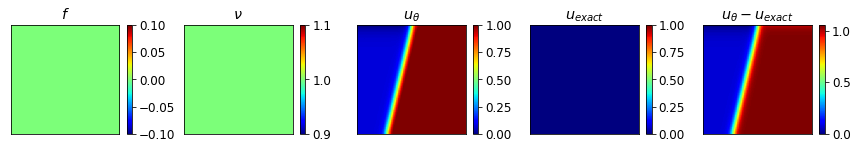

In [4]:
# Query
basecase.dataset[0]
inputs, forcing = basecase.dataset[0]
k, f, u = basecase.do_query(inputs, forcing) 
u_exact = basecase.u_exact.squeeze()
# L2 error calculation
basecase.calc_l2_err()
# plot
plot_contours(k,f,u,u_exact)

Text(0.5, 1.0, '$u_{\\theta}-u_{exact}$')

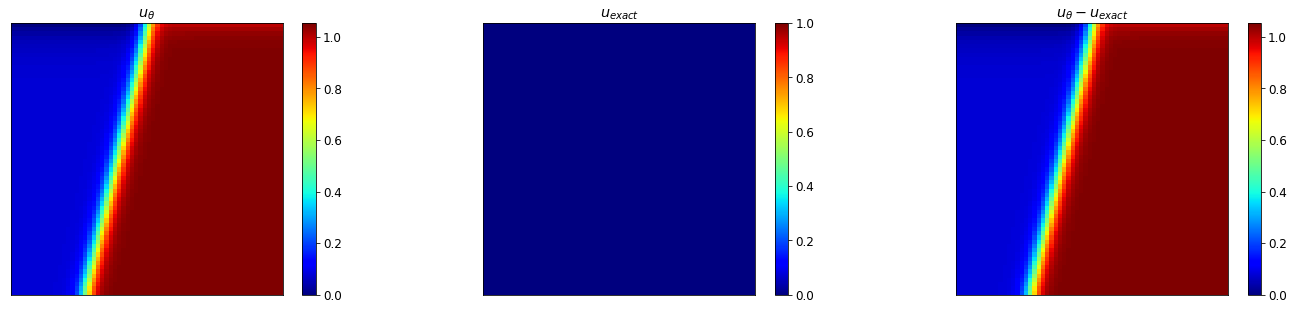

In [5]:
diff = u - u_exact
# plotting        
fig, axs = plt.subplots(1, 3, figsize=(8*3,5),
                    subplot_kw={'aspect': 'auto'}, sharex=True, sharey=True, squeeze=True)
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])              

im = axs[0].imshow(u,cmap='jet')
fig.colorbar(im, ax=axs[0]); axs[0].set_title(r'$u_{\theta}$')
im = axs[1].imshow(u_exact,cmap='jet', vmin=0.0, vmax=1.0)
fig.colorbar(im, ax=axs[1]); axs[1].set_title(r'$u_{exact}$')
im = axs[2].imshow(diff,cmap='jet')
fig.colorbar(im, ax=axs[2]); axs[2].set_title(r'$u_{\theta}-u_{exact}$')

(0.0, 0.005)

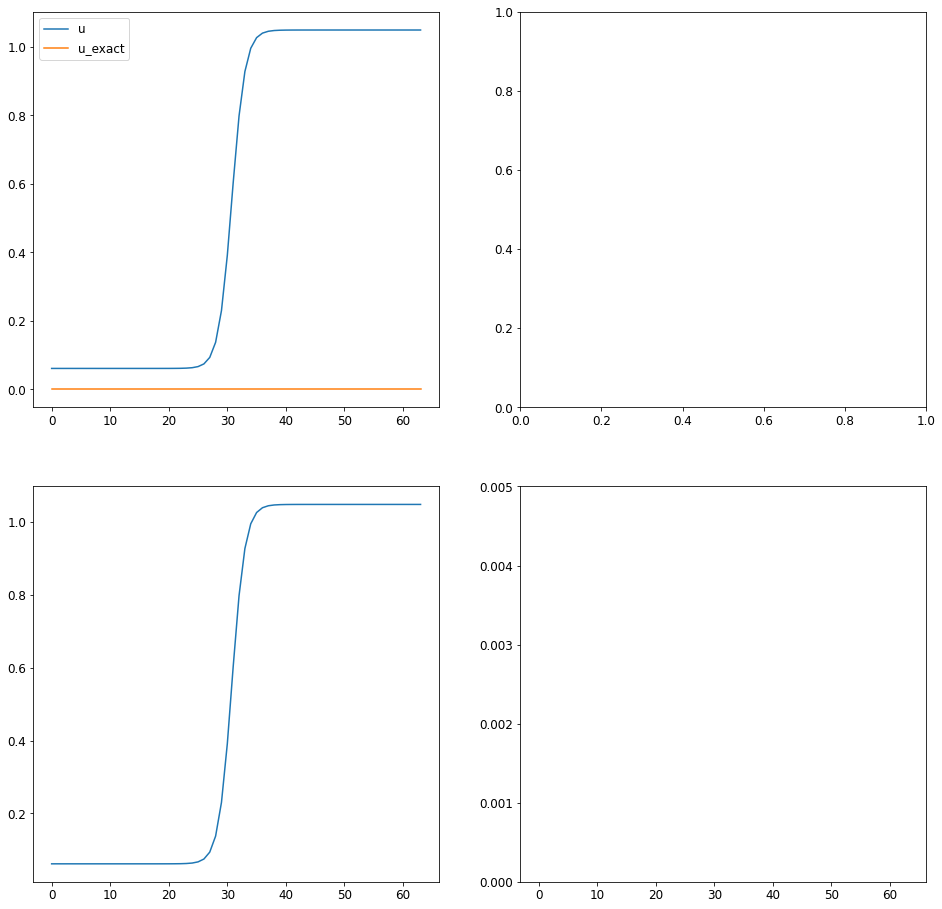

In [6]:
idx = 5

diff = u - u_exact
# plotting        
fig, axs = plt.subplots(2, 2, figsize=(16,16),
                    subplot_kw={'aspect': 'auto'}, sharex=False, sharey=False, squeeze=True)
# for ax in axs:
#     ax.set_xticks([])
#     ax.set_yticks([])              

im = axs[0,0].plot(u[idx,:], label='u')
im = axs[0,0].plot(u_exact[idx,:], label='u_exact')
axs[0,0].legend()
im = axs[1,0].plot(diff[idx,:])
im = axs[1,1].plot(np.abs(diff[idx,:])); axs[1,1].set_ylim([0,0.005])
# fig.colorbar(im, ax=axs[0]); axs[0].set_title(r'$u_{\theta}$')
# im = axs[1].imshow(u_exact,cmap='jet', vmin=0.0, vmax=1.0)
# fig.colorbar(im, ax=axs[1]); axs[1].set_title(r'$u_{exact}$')
# im = axs[2].imshow(diff,cmap='jet')
# fig.colorbar(im, ax=axs[2]); axs[2].set_title(r'$u_{\theta}-u_{exact}$')

In [7]:
basecase.gamma

126.0

In [8]:
np.exp(basecase.gamma)

5.261441182666386e+54

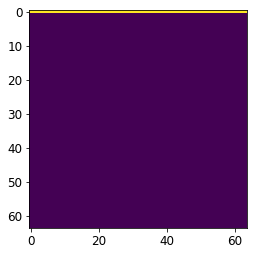

In [9]:
plt.imshow(basecase.dataset.bc1)

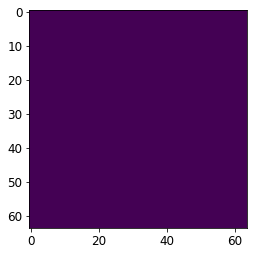

In [10]:
plt.imshow(basecase.dataset.bc2)

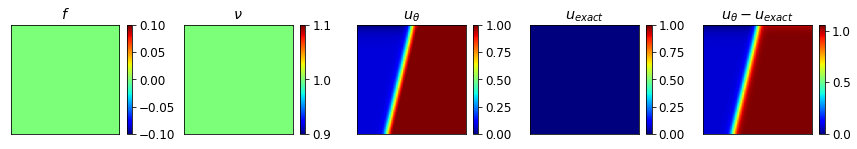

nsample =  100


In [11]:
# separate query
version_id = 23
case_dir = './allen-cahn-icemelt-2d/version_'+str(version_id)
dataset = AllenCahnIceMeltRectangle(domain_size=domain_size)
network = torch.load(os.path.join(case_dir, 'network.pt'))
equation = AllenCahnIceMelt(network, dataset, batch_size=1, domain_size=domain_size)
# Query
inputs, forcing = equation.dataset[0]
k, f, u = equation.do_query(inputs, forcing) 
u_exact = equation.u_exact.squeeze()

# plot
plot_contours(k,f,u,u_exact)

nsample = len(basecase.dataset)
print("nsample = ", nsample)

Text(0.5, 1.0, '$u_{\\theta}-u_{exact}$')

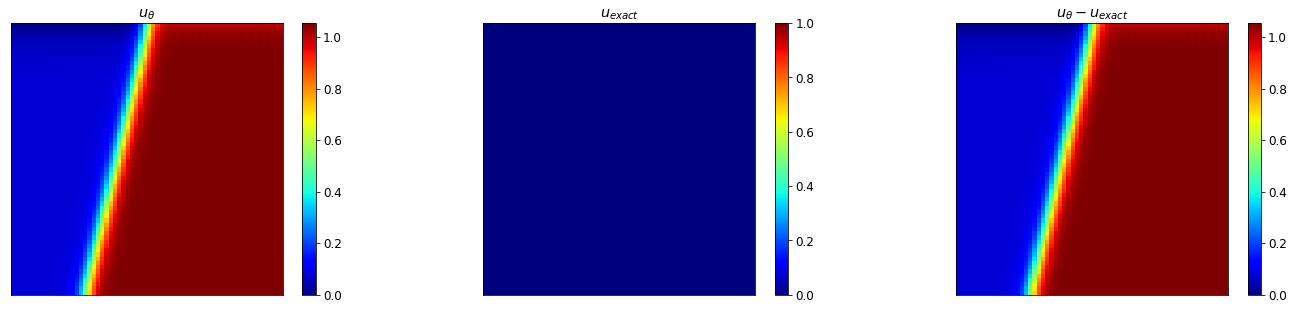

In [12]:
diff = u - u_exact
# plotting        
fig, axs = plt.subplots(1, 3, figsize=(8*3,5),
                    subplot_kw={'aspect': 'auto'}, sharex=True, sharey=True, squeeze=True)
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])              

im = axs[0].imshow(u,cmap='jet')
fig.colorbar(im, ax=axs[0]); axs[0].set_title(r'$u_{\theta}$')
im = axs[1].imshow(u_exact,cmap='jet', vmin=0.0, vmax=1.0)
fig.colorbar(im, ax=axs[1]); axs[1].set_title(r'$u_{exact}$')
im = axs[2].imshow(diff,cmap='jet')
fig.colorbar(im, ax=axs[2]); axs[2].set_title(r'$u_{\theta}-u_{exact}$')

(0.0, 0.005)

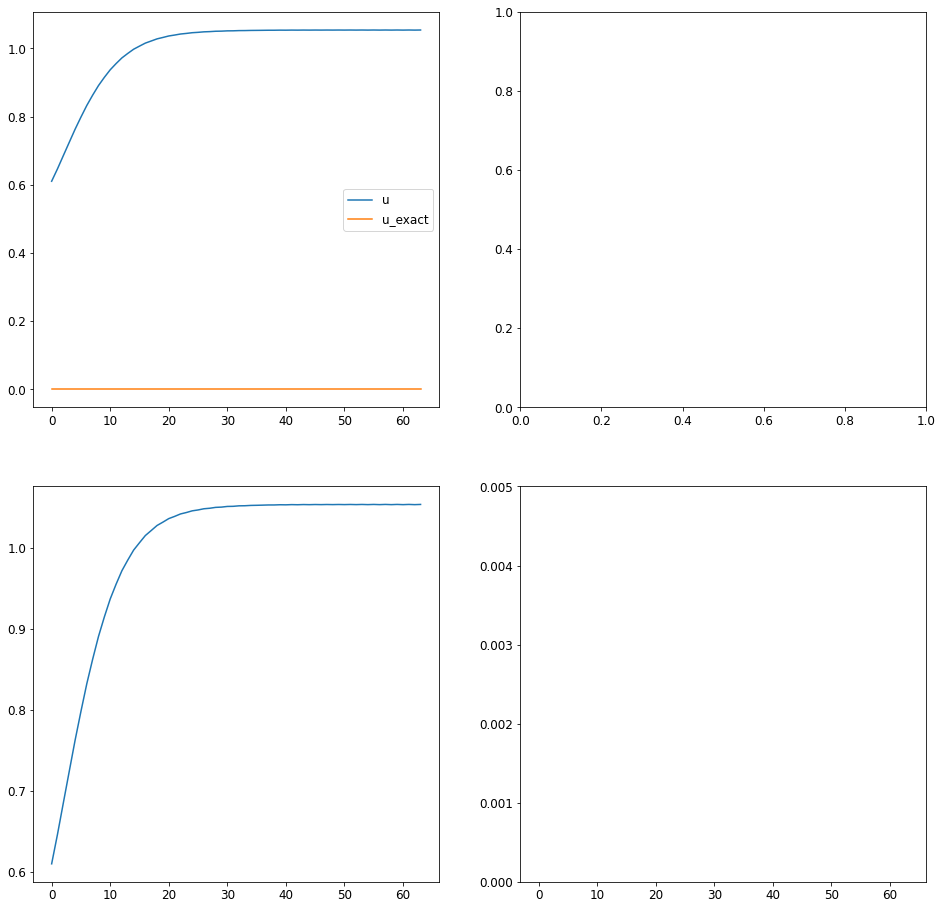

In [13]:
idx = 32

diff = u - u_exact
# plotting        
fig, axs = plt.subplots(2, 2, figsize=(16,16),
                    subplot_kw={'aspect': 'auto'}, sharex=False, sharey=False, squeeze=True)
# for ax in axs:
#     ax.set_xticks([])
#     ax.set_yticks([])              

m = axs[0,0].plot(u[:,idx], label='u')
im = axs[0,0].plot(u_exact[:,idx], label='u_exact')
axs[0,0].legend()
im = axs[1,0].plot(diff[:,idx])
im = axs[1,1].plot(np.abs(diff[:,idx])); axs[1,1].set_ylim([0,0.005])

In [14]:
num_data = np.loadtxt("ac_data_csv.csv", delimiter=",", skiprows=1)
u_num_v = num_data[:,0]

In [15]:
u_num = np.reshape(u_num_v, (domain_size, domain_size))

In [16]:
# u_num = dump['U_sol']
# u_num = u_num.reshape((64,64))

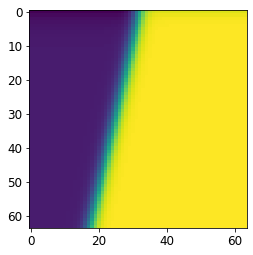

In [17]:
plt.imshow(u_num)

Text(0.5, 1.0, '$u_{\\theta}-u_{num}$')

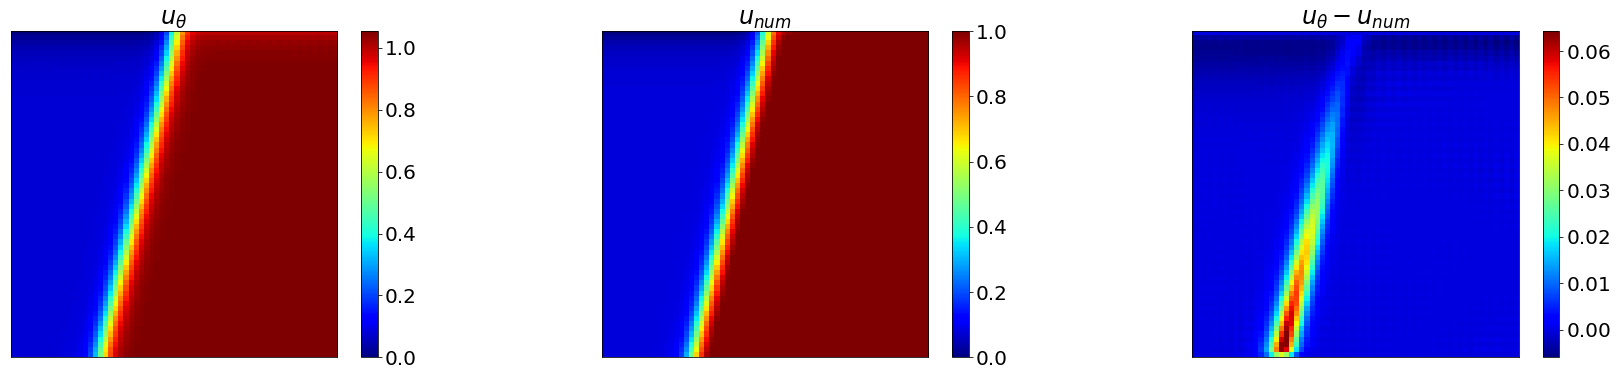

In [26]:
diff = u - u_num
# plotting        
matplotlib.rcParams.update({
    # 'font.family': 'serif',
    'font.size':20,
})
fig, axs = plt.subplots(1, 3, figsize=(30,6),
                    subplot_kw={'aspect': 'auto'}, sharex=True, sharey=True, squeeze=True)
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])              

im = axs[0].imshow(u,cmap='jet')
fig.colorbar(im, ax=axs[0]); axs[0].set_title(r'$u_{\theta}$')
im = axs[1].imshow(u_num,cmap='jet', vmin=0.0, vmax=1.0)
fig.colorbar(im, ax=axs[1]); axs[1].set_title(r'$u_{num}$')
im = axs[2].imshow(diff,cmap='jet')
fig.colorbar(im, ax=axs[2]); axs[2].set_title(r'$u_{\theta}-u_{num}$')

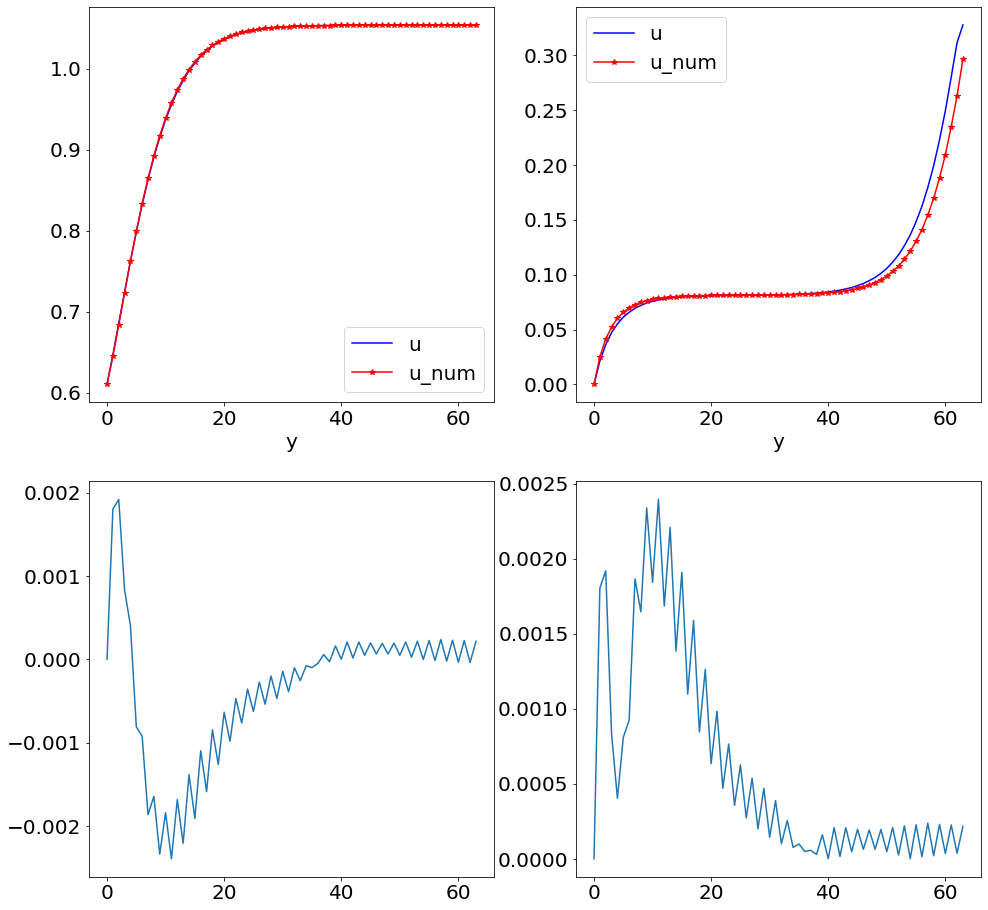

In [28]:
idx = 32

diff = u - u_num
# plotting        
fig, axs = plt.subplots(2, 2, figsize=(16,16),
                    subplot_kw={'aspect': 'auto'}, sharex=False, sharey=False, squeeze=True)
# for ax in axs:
#     ax.set_xticks([])
#     ax.set_yticks([])              

im = axs[0,0].plot(u[:,idx],'b-', label='u')
im = axs[0,0].plot(u_num[:,idx],'r*-', label='u_num')
axs[0,0].legend()
axs[0,0].set_xlabel('y')
im = axs[0,1].plot(u[:,16],'b-', label='u')
im = axs[0,1].plot(u_num[:,16],'r*-', label='u_num')
axs[0,1].legend()
axs[0,1].set_xlabel('y')
im = axs[1,0].plot(diff[:,idx])
im = axs[1,1].plot(np.abs(diff[:,idx])); #axs[1,1].set_ylim([0,0.005])

In [20]:
basecase.dataset.bc2[12,0]

0.0

In [21]:
int(0.2*domain_size)

12

In [22]:
0.2*64

12.8